In [ ]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install kaggle kagglehub
%pip install Pillow
%pip install matplotlib


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [04:16<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Ruta del directorio del conjunto de datos
dataset_path = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2"

# Cargar el archivo CSV de metadatos
metadata_path = os.path.join(dataset_path, "HAM10000_metadata.csv")
df = pd.read_csv(metadata_path)

# Prepara las rutas de las imágenes
image_dirs = [
    os.path.join(dataset_path, "HAM10000_images_part_1"),
    os.path.join(dataset_path, "HAM10000_images_part_2"),
]

# Generar rutas para las imágenes
df['path'] = df['image_id'].map(lambda x: [os.path.join(image_dir, f"{x}.jpg") for image_dir in image_dirs])
df['path'] = df['path'].apply(lambda x: x[0] if os.path.exists(x[0]) else x[1] if os.path.exists(x[1]) else None)

# Contar el número de imágenes por clase
class_counts = df['dx'].value_counts()
print(class_counts)

# Especificar la clase a reducir y la cantidad deseada
class_to_reduce = 'nv'  # Por ejemplo, "nv" para lunares
reduction_factor = 0.4  # Mantener el 60% de las imágenes de lunares
target_count = int(class_counts[class_to_reduce] * reduction_factor)

# Filtrar las imágenes de lunares y seleccionar aleatoriamente
lunar_images = df[df['dx'] == class_to_reduce].sample(n=target_count, random_state=42)
non_lunar_images = df[df['dx'] != class_to_reduce]

# Combinar las imágenes de lunares reducidas con las demás clases
df_balanced = pd.concat([lunar_images, non_lunar_images])

# Dividir el conjunto de datos en entrenamiento y validación
train_df, valid_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['dx'], random_state=42)

# Imprimir el conteo final de las clases
print(train_df['dx'].value_counts())
print(valid_df['dx'].value_counts())


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
dx
nv       2145
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       537
mel      223
bkl      220
bcc      103
akiec     65
vasc      28
df        23
Name: count, dtype: int64


In [12]:
# Definir las configuraciones de los generadores
train_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Crear generadores de datos
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=(224, 224),  # Cambiado a (224, 224) para que coincida con el tamaño esperado por MobileNetV2
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    validate_filenames=False  # Evita la validación de nombres de archivos
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='dx',
    target_size=(224, 224),  # Cambiado a (224, 224) para que coincida con el tamaño esperado por MobileNetV2
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    validate_filenames=False  # Evita la validación de nombres de archivos
)


Found 4793 non-validated image filenames belonging to 7 classes.
Found 1199 non-validated image filenames belonging to 7 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Cargar el modelo MobileNetV2 preentrenado sin las capas superiores
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas de la base
base_model.trainable = False



# Construir el modelo con capas de normalización y dropout
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalización inicial de los valores de los píxeles
    base_model,
    layers.BatchNormalization(),                   # Capa de normalización después de la base preentrenada
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),                           # Dropout para regularización
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),                   # Otra capa de normalización
    layers.Dropout(0.5),                           # Dropout adicional
    layers.Dense(len(df['dx'].unique()), activation='softmax')  # Salida con softmax para clasificación multiclase
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Configurar Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',        # Monitorea la pérdida en el conjunto de validación
    patience=3,                # Detiene el entrenamiento después de 3 épocas sin mejora
    restore_best_weights=True  # Restaura los pesos del mejor modelo logrado
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,                      # Puedes ajustar el número máximo de épocas
    callbacks=[early_stop]           # Callback de early stopping
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 656ms/step - accuracy: 0.2966 - loss: 1.9079 - val_accuracy: 0.0542 - val_loss: 2.0174
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 553ms/step - accuracy: 0.4452 - loss: 1.7565 - val_accuracy: 0.0550 - val_loss: 1.9811
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 552ms/step - accuracy: 0.4697 - loss: 1.6585 - val_accuracy: 0.1835 - val_loss: 1.9251
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 550ms/step - accuracy: 0.4738 - loss: 1.6228 - val_accuracy: 0.4470 - val_loss: 1.8580
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 557ms/step - accuracy: 0.4924 - loss: 1.5542 - val_accuracy: 0.4737 - val_loss: 1.7845
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 559ms/step - accuracy: 0.5052 - loss: 1.5240 - val_accuracy: 0.4996 - val_loss: 1.6924
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 556ms/step - accuracy: 0.5005 - loss: 1.4886 - val_accuracy: 0.4987 - val_loss: 1.5865
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 558ms/step - accuracy: 0.5060 - loss: 1.4496 - val_accuracy: 0.500

In [15]:
# Evaluar el modelo en el conjunto de validación
loss, accuracy = model.evaluate(valid_generator, steps=len(valid_df) // 32)
print(f"Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.5190 - loss: 1.2717
Pérdida: 1.2401, Precisión: 0.5329


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


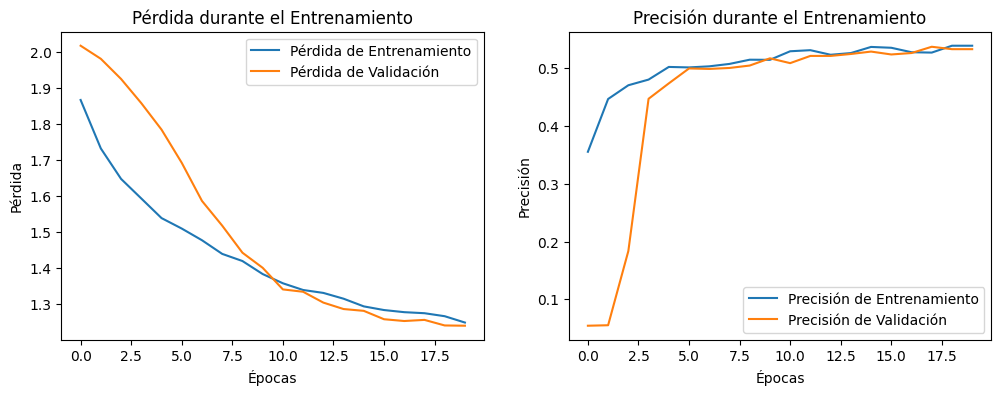

In [16]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()


In [21]:
import numpy as np

# Obtener las predicciones del modelo
predictions = model.predict(valid_generator)

# Obtener las clases predichas (convertir probabilidades a clases)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las clases verdaderas
true_classes = valid_generator.classes

# Comprobar las formas de las clases
print(f"Número de clases verdaderas: {len(true_classes)}")
print(f"Número de clases predichas: {len(predicted_classes)}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step
Número de clases verdaderas: 1199
Número de clases predichas: 1199


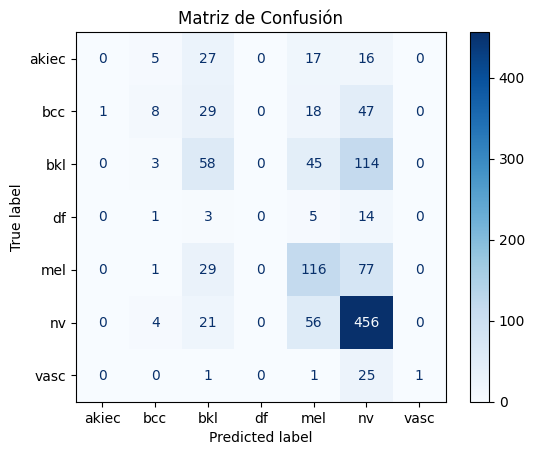

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step


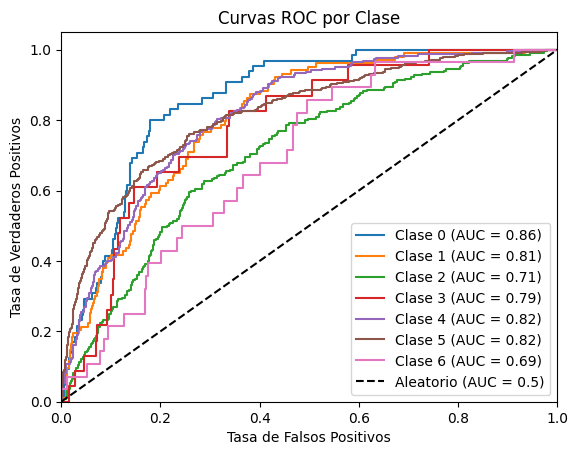

Mejor umbral para la clase 0: 0.10 con F1 Score: 0.33
Mejor umbral para la clase 1: 0.13 con F1 Score: 0.34
Mejor umbral para la clase 2: 0.19 con F1 Score: 0.43
Mejor umbral para la clase 3: 0.06 con F1 Score: 0.14
Mejor umbral para la clase 4: 0.24 con F1 Score: 0.52
Mejor umbral para la clase 5: 0.36 con F1 Score: 0.73
Mejor umbral para la clase 6: 0.08 con F1 Score: 0.09


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize

# Obtener las predicciones del modelo en el conjunto de validación
predictions = model.predict(valid_generator)
# Las clases verdaderas
true_classes = valid_generator.classes
# Convertir las clases verdaderas a un formato binarizado
n_classes = len(valid_generator.class_indices)  # Número de clases
true_classes_bin = label_binarize(true_classes, classes=np.arange(n_classes))

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
best_thresholds = dict()
f1_scores = dict()

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular el F1 Score para cada umbral
    f1_scores[i] = []
    for threshold in thresholds[i]:
        predicted_classes = (predictions[:, i] >= threshold).astype(int)
        f1 = f1_score(true_classes_bin[:, i], predicted_classes)
        f1_scores[i].append(f1)

    # Encontrar el índice del mejor F1 Score
    best_index = np.argmax(f1_scores[i])
    best_thresholds[i] = thresholds[i][best_index]

# Graficar la curva ROC para cada clase
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Graficar la diagonal de referencia (la línea de no discriminación)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Clase')
plt.legend(loc="lower right")
plt.show()

# Mostrar los mejores umbrales para cada clase
for i in range(n_classes):
    print(f'Mejor umbral para la clase {i}: {best_thresholds[i]:.2f} con F1 Score: {max(f1_scores[i]):.2f}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step
              precision    recall  f1-score   support

       akiec       0.22      0.69      0.33        65
         bcc       0.24      0.55      0.34       103
         bkl       0.34      0.60      0.43       220
          df       0.08      0.52      0.14        23
         mel       0.41      0.70      0.52       223
          nv       0.79      0.58      0.67       537
        vasc       0.13      0.07      0.09        28

   micro avg       0.41      0.60      0.48      1199
   macro avg       0.32      0.53      0.36      1199
weighted avg       0.53      0.60      0.53      1199
 samples avg       0.45      0.60      0.49      1199



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


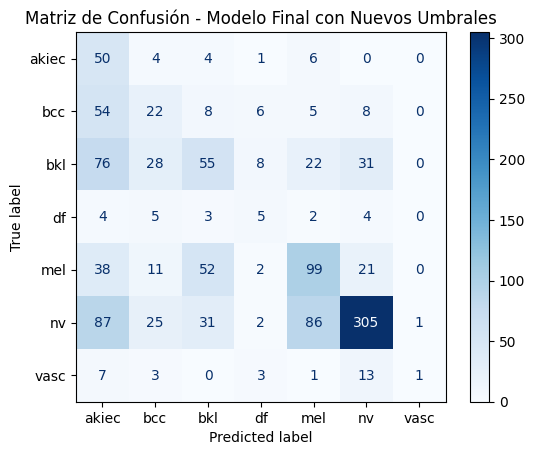

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

# Obtener las predicciones del modelo en el conjunto de validación
predictions = model.predict(valid_generator)

# Las clases verdaderas
true_classes = valid_generator.classes

# Convertir las clases verdaderas a un formato binarizado
n_classes = len(valid_generator.class_indices)
true_classes_bin = label_binarize(true_classes, classes=np.arange(n_classes))

# Definir un nuevo umbral para la clase 'nv'
nv_class_index = valid_generator.class_indices['nv']  # Obtener el índice de la clase 'nv'
new_nv_threshold = 0.60  # Ajusta este valor según lo necesario
new_thresholds = best_thresholds.copy()  # Copiar los umbrales existentes
new_thresholds[nv_class_index] = new_nv_threshold  # Establecer un nuevo umbral para 'nv'

# Crear un array para las predicciones finales
final_predictions = np.zeros_like(predictions)

# Aplicar los nuevos umbrales para obtener las predicciones finales
for i in range(n_classes):
    final_predictions[:, i] = (predictions[:, i] >= new_thresholds[i]).astype(int)

# Convertir las predicciones finales de vuelta a etiquetas de clase
predicted_classes = np.argmax(final_predictions, axis=1)

# Evaluar el modelo final
print(classification_report(true_classes_bin, final_predictions, target_names=valid_generator.class_indices.keys()))

# Obtener la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Modelo Final con Nuevos Umbrales')
plt.show()


In [25]:
# Guardar el modelo en formato HDF5
model.save('modelo_piel2.h5')
